# FADAPS4
### Fine-grained Adversarial Domain Adapation with Pseudo-probability Smoothing and Sample Selection Strategy

In [2]:
# basic packages
from math import log
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
import os
import shutil
import random
from imutils import paths
from pathlib import Path
from collections import defaultdict
import pandas as pd
from tabulate import tabulate
import time
import gc
from scipy.stats import entropy
import math
import csv

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
from tensorflow import keras
import keras.backend as K

# sklearn
import sklearn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from keras.utils import to_categorical 

In [3]:
print('Num GPUs available:', len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
# check tf version
print('Tensorflow version:', tf.__version__)

Num GPUs available: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11781605020490698477
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10045358080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14872650598867905633
physical_device_desc: "device: 0, name: NVIDIA RTX A3000 12GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Tensorflow version: 2.9.0


In [4]:
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Initialization

In [6]:
# basic initialization
BS = 8
INIT_LR = 0.001
seed = 42
alpha = 0.001 # Rate at which discriminator loss influences generator (feature extractor) training (FADA)
conf_thres = 0.9 # 0.9 as suggested in the source literature (FADA)
EPOCH = 100
patience = EPOCH * 0.2
save_dir = 'FADAPS4-mods'
model_name = 'PTM-MC-SZ-e06p06b07l7v3'

ent_thres = 0.6 # Sample Selection (DeYO)
plpd_thres = 0.6 # Sample Selection (DeYO)
beta = 0.7 # [0.5, 0.6, 0.7, 0.8, 0.9] Smoothing (SFDA with Noisy Labels)
lamda = 7 # [1, 3, 7, 12, 25] Smoothing (SFDA with Noisy Labels)

dataTrain_sc = '../../A1-TrainTest/MC-aug' # source train set
dataTest_sc = '../../A1-TrainTest/MC-test-CLAHE' # source test set
mdlDirs_sc = ['../../A1-TrainTest/EfficientNet-B1/n-EfficientNetB1-MC-mod'] # as PTM and shared with target domain - direct_best/single model
data_tar = '../../TBGenData/MC_to_SZ-test-CLAHE' # overall target dataset

last_layers_len = 5

n_fold = 5 # data will be split into 5 partitions (80% train and 20% validation)
baseFold = 1 # baseFold to be used

# input image sizes
img_sizes = [240] # B1
k = 1 # number of classifiers in the ensemble method - we used only 1 PTM
ft = 340 # 7th/full block of EffB1

In [7]:
# loading data
def loadData(data_dir, img_size):
    # all images in the directory are taken
    data_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(img_size, img_size),
        batch_size=BS)
    class_names = data_ds.class_names
    print(class_names)
    print(f'Data_ds length: {len(data_ds)}')
    print(f'Batch: {BS}')
    print(f'Approx images in data_ds: {len(data_ds) * BS}')
    # Here are the first nine images from the dataset (first batch)
    plt.figure(figsize=(10, 10))
    for images, labels in data_ds.take(1):
        for i in range(6):
            ax = plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

    # extract the batch dataset image (x) and label (y)
    x = np.concatenate([x for x, y in data_ds], axis=0)
    y = np.concatenate([y for x, y in data_ds], axis=0)
    
    return data_ds, x, y

In [8]:
# loading model
def loadModel(cl, ft, mdl_dir):
    # load the best model - single direct
    bmodel = load_model(mdl_dir)
    
    # show several last layers from built models
    # Create empty dictionary list
    layers_summary = defaultdict(list)
    # Iterate over the selected layers
    for layer in bmodel.layers[-last_layers_len:]:
        layers_summary['Layer'].append(layer.name) # layer name
        layers_summary['Output Shape'].append(layer.output_shape) # layer output shape
        layers_summary['Param #'].append(layer.count_params()) # layer parameter size
    # Convert to pandas dataframe
    layers_df = pd.DataFrame.from_dict(layers_summary) 
    # Tabulate df
    print("Model head summary:")
    print(tabulate(layers_df, headers = 'keys', tablefmt = 'github')+"\n")

    return bmodel

In [9]:
img_size = img_sizes[0] # default image size for consistency
mdlDir = mdlDirs_sc[0] # the PTM (here we use the PTM from source dataset)

Found 3296 files belonging to 2 classes.
['Normal', 'TB']
Data_ds length: 412
Batch: 8
Approx images in data_ds: 3296


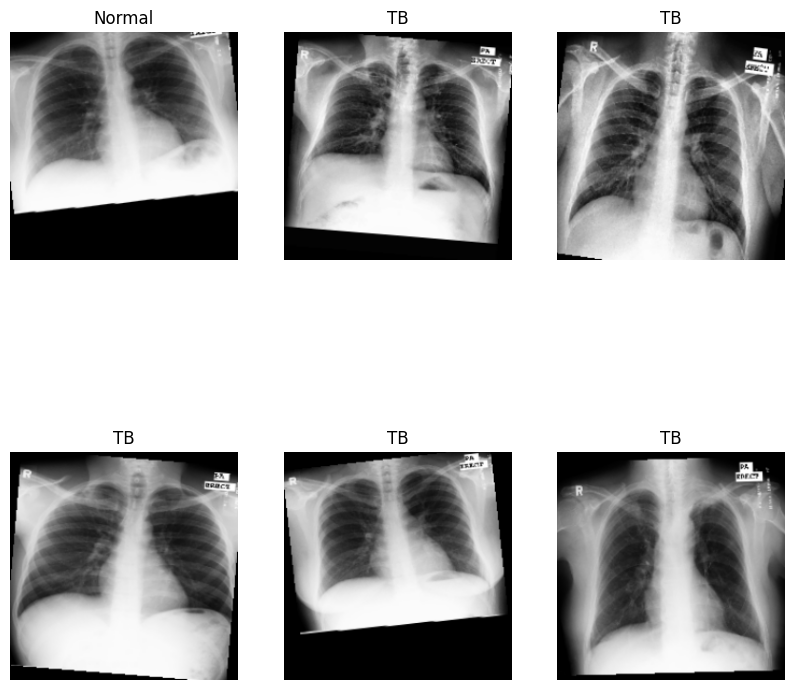

Found 28 files belonging to 2 classes.
['Normal', 'TB']
Data_ds length: 4
Batch: 8
Approx images in data_ds: 32


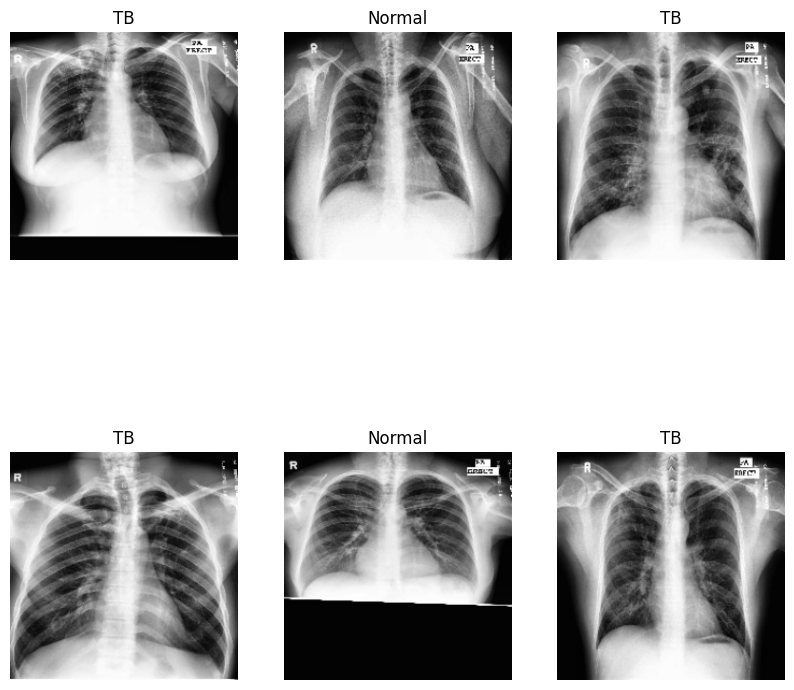

Length data source (train): (3296, 240, 240, 3) (3296,)
Length data source (test): (28, 240, 240, 3) (28,)
Found 662 files belonging to 2 classes.
['Normal', 'TB']
Data_ds length: 83
Batch: 8
Approx images in data_ds: 664


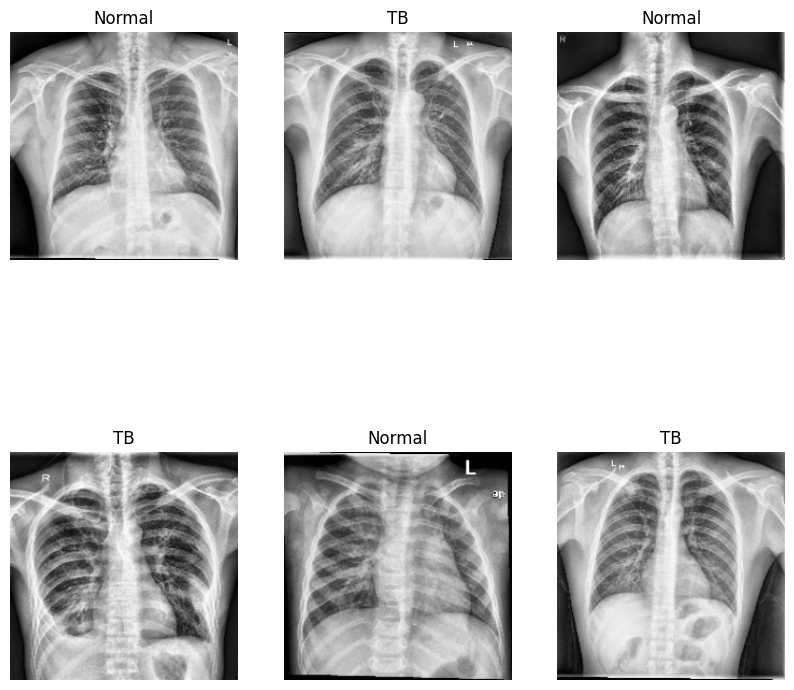

Length data target: (662, 240, 240, 3) (662,)


In [10]:
# reload source data set for base fold based on Train and Test split
datTrain_sc = dataTrain_sc + '-' + str(baseFold)
datTest_sc = dataTest_sc + '-' + str(baseFold)
sc_train_ds, xs_train, ys_train = loadData(datTrain_sc, img_size)
sc_test_ds, xs_test, ys_test = loadData(datTest_sc, img_size)
print('Length data source (train):', xs_train.shape, ys_train.shape)
print('Length data source (test):', xs_test.shape, ys_test.shape)
print('==='*50)

# reload target data set
tar_ds, xt_all, yt_all = loadData(data_tar, img_size)
print('Length data target:', xt_all.shape, yt_all.shape)

In [11]:
print('Load PTM')
# check the dir to load best models
mdir = mdlDir + '-' + str(baseFold)
model_ptm = mdir + '/direct_best.h5' # focus on the best performing models - single direct

Load PTM


# PTM Result

In [12]:
# optimize the performance
AUTOTUNE = tf.data.AUTOTUNE
sc_train_ds = sc_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
sc_test_ds = sc_test_ds.cache().prefetch(buffer_size=AUTOTUNE)
tar_ds = tar_ds.cache().prefetch(buffer_size=AUTOTUNE)

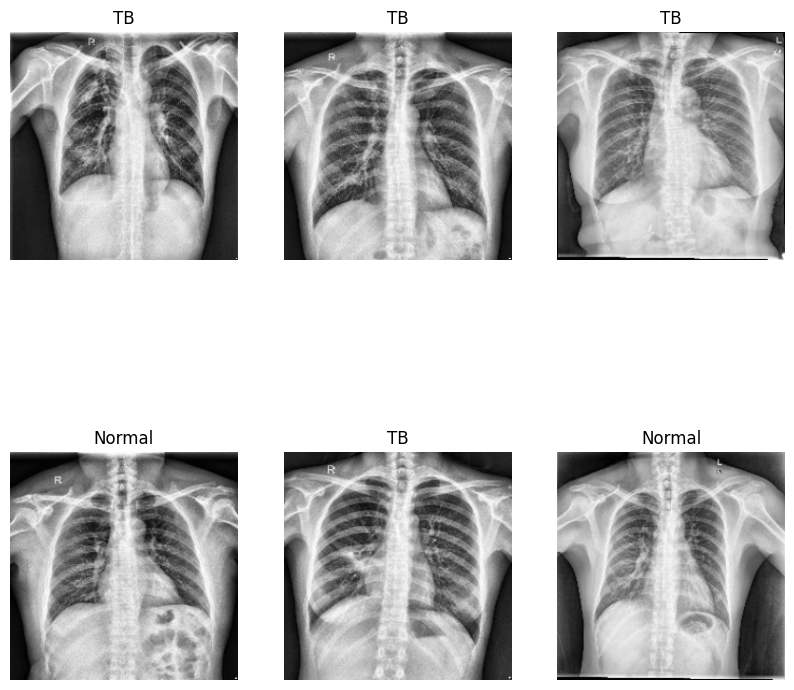

In [13]:
# check several images from the target
cl_nm = ['Normal', 'TB']
plt.figure(figsize=(10, 10))
for images, labels in tar_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(cl_nm[labels[i]])
        plt.axis("off")
plt.show()

In [14]:
# function to calculate the model performance
def perf_metrics(correct_labels, predicted_labels, class_names=["Normal", "TB"]):
    print("Classification Report")
    print(classification_report(correct_labels, predicted_labels, target_names=class_names))
    
    print('Confusion Matrix:\n',confusion_matrix(correct_labels, predicted_labels))
    # CM visualization
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(correct_labels, predicted_labels),
                                                display_labels = class_names)
    cm_display.plot(cmap='Greys')
    plt.show()
    
    # print accuracy_score, precision_score, recall_score, f1_score
    acc = accuracy_score(correct_labels, predicted_labels)*100
    sens = recall_score(correct_labels, predicted_labels)*100
    spec = recall_score(correct_labels, predicted_labels, pos_label=0)*100
    prec = precision_score(correct_labels, predicted_labels)*100
    f1 = f1_score(correct_labels, predicted_labels)*100
    print('\nAccuracy: {:.4f}\n'.format(acc))
    print('Recall/Sensitivity: {:.4f}\n'.format(sens))
    print('Specificity: {:.4f}\n'.format(spec))
    print('Precision: {:.4f}\n'.format(prec))
    print('F1-score: {:.4f}\n'.format(f1))
    return acc, sens, spec, prec, f1

In [15]:
# function to check the accuracy of PTM on Test set
def perfEval(k, ft, model_v, test_ds):
    pred_ens = []
    for i in range(k):
        print('Model name:', model_v)
        # load the best model
        bmodel = load_model(model_v)
        
        # show several last layers from built models
        # Create empty dictionary list
        layers_summary = defaultdict(list)
        # Iterate over the selected layers
        for layer in bmodel.layers[-last_layers_len:]:
            layers_summary['Layer'].append(layer.name) # layer name
            layers_summary['Output Shape'].append(layer.output_shape) # layer output shape
            layers_summary['Param #'].append(layer.count_params()) # layer parameter size
        # Convert to pandas dataframe
        layers_df = pd.DataFrame.from_dict(layers_summary) 
        # Tabulate df
        print("Model "+str(i+1)+" head summary:")
        print(tabulate(layers_df, headers = 'keys', tablefmt = 'github')+"\n")
        
        y_pred = []  # store predicted labels
        y_true = []  # store true labels
        y_prob = []  # store predict proba labels
        # iterate over the dataset
        for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
            print("-------------------------------")
            # append true labels
            y_true.append(label_batch)
            # compute predictions
            preds = bmodel.predict(image_batch)
            # append predicted labels
            y_pred.append(np.argmax(preds, axis = -1))
            # append predict proba labels - for auc curve
            y_prob.append(preds)
        # convert the true and predicted labels into tensors
        correct_labels = tf.concat([item for item in y_true], axis = 0)
        predicted_labels = tf.concat([item for item in y_pred], axis = 0)
        proba_labels = tf.concat([item for item in y_prob], axis = 0)
        # add the prediction results into pred_ens
        pred_ens.append(proba_labels)
        print("================================")
    
        print('1A. Single (Direct) Prediction Results')
        print('Actual labels: ', correct_labels)
        print('Predicted labels:', predicted_labels)
        acc, sens, spec, prec, f1 = perf_metrics(correct_labels, predicted_labels)
        # convert proba_labels to np.array
        proba_labels = np.array(proba_labels)
        # calculate the ROC AUC
        fpr, tpr, threshold = metrics.roc_curve(correct_labels, proba_labels[:,1])
        roc_auc = metrics.auc(fpr, tpr)
        # plot the curve
        plt.title('Receiver Operating Characteristic AUC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %.4f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        print('============================')

    print('Ensemble Prediction Model using', k,' Classifiers')
    predicted_ens = [pred_ens[j] for j in range(k)]
    predicted_ens = np.array(predicted_ens)
    # sum across ensemble results
    summed = np.sum(predicted_ens, axis=0)
    # argmax across classes as our prediction results
    ens_pred_labels = np.argmax(summed, axis=1)
    print('Actual labels: ', correct_labels)
    print('Predicted labels:', ens_pred_labels)
    acc, sens, spec, prec, f1 = perf_metrics(correct_labels, ens_pred_labels)
    # calculate the ROC AUC
    fpr, tpr, threshold = metrics.roc_curve(correct_labels, summed[:,1]/k)
    roc_auc = metrics.auc(fpr, tpr)
    # plot the curve
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('============================')
    
    del bmodel, fpr, tpr, threshold, layers_df
    return acc, sens, spec, prec, f1, roc_auc, proba_labels, correct_labels

# Direct PTM (Source -> Target)

Model name: ../../A1-TrainTest/EfficientNet-B1/n-EfficientNetB1-MC-mod-1/direct_best.h5
Model 1 head summary:
|    | Layer   | Output Shape   |   Param # |
|----|---------|----------------|-----------|
|  0 | flatten | (None, 5120)   |         0 |
|  1 | Top1    | (None, 256)    |   1310976 |
|  2 | Top2    | (None, 512)    |    131584 |
|  3 | dropout | (None, 512)    |         0 |
|  4 | TopF    | (None, 2)      |      1026 |

-------------------------------
1/1 [==============================] - 15s 15s/step
-------------------------------
1/1 [==============================] - 0s 119ms/step
-------------------------------
1/1 [==============================] - 0s 110ms/step
-------------------------------
1/1 [==============================] - 0s 117ms/step
-------------------------------
1/1 [==============================] - 0s 115ms/step
-------------------------------
1/1 [==============================] - 0s 119ms/step
-------------------------------
1/1 [=====================

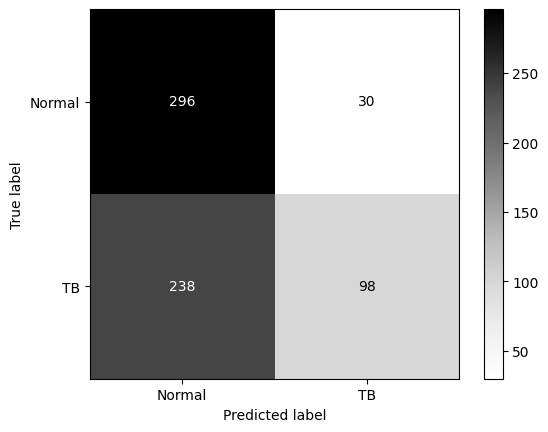


Accuracy: 59.5166

Recall/Sensitivity: 29.1667

Specificity: 90.7975

Precision: 76.5625

F1-score: 42.2414



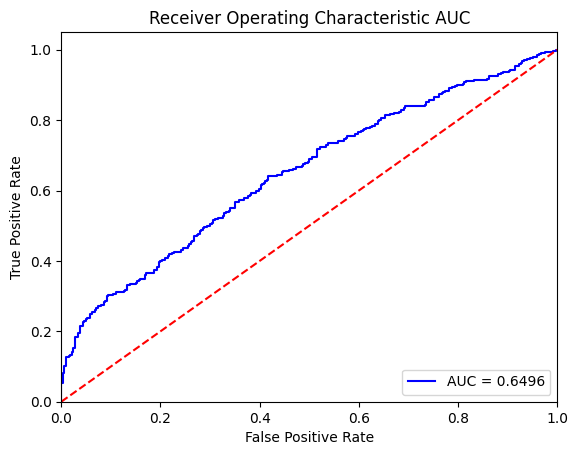

Ensemble Prediction Model using 1  Classifiers
Actual labels:  tf.Tensor(
[1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1
 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 0 1 1 0 1 0 1

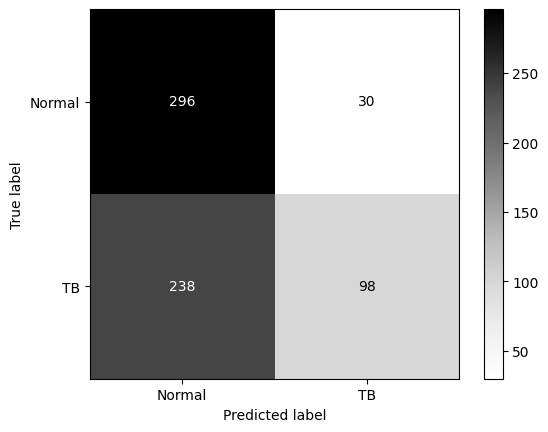


Accuracy: 59.5166

Recall/Sensitivity: 29.1667

Specificity: 90.7975

Precision: 76.5625

F1-score: 42.2414



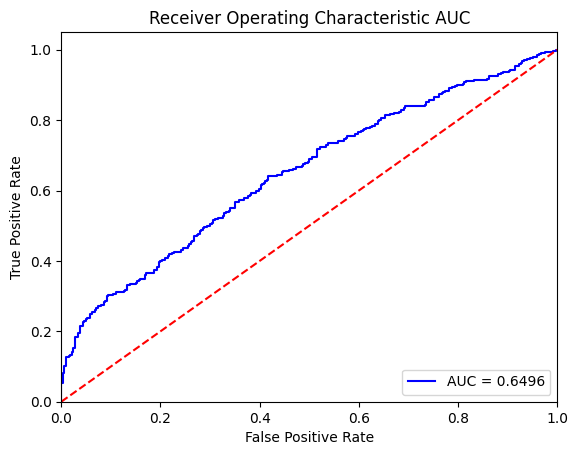

Execution time: 46.54734650001046
Actual labels:  tf.Tensor(
[1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1
 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 

In [16]:
# evaluate on target set
start_counter = time.perf_counter()
acc_t, sens_t, spec_t, prec_t, f1_t, roc_auc_t, summed_pred_t, act_lbl_t = perfEval(k, ft, model_ptm, tar_ds)
end_counter = time.perf_counter()
timer = end_counter - start_counter
print('Execution time:', timer)

print('Actual labels: ', act_lbl_t)
ens_pred_t = summed_pred_t
ens_pred_lbl_t = np.argmax(summed_pred_t, axis=1)
print('Predicted labels:', ens_pred_lbl_t)
print('Summed Predict Proba:', ens_pred_t)

## Entropy calculation

In [18]:
def calc_entropy(ens_pred, base=2):
    H_All = entropy(np.transpose(ens_pred), base=base)
    SR_All = np.max(ens_pred, axis=1)
    return H_All, SR_All

In [19]:
def plot_ce(ents, ce_thres, lbls=None):
    plt.scatter(range(len(ents)), ents, marker='.', c=lbls, cmap='Set1')
    plt.axhline(y=ce_thres, color='k', linestyle='--', label='Entropy threshold: ' + str(np.round(ce_thres,2)))
    plt.title('Entropy')
    plt.subplots_adjust(bottom=0.2)
    plt.xlabel('Index')
    plt.ylabel('Entropy (nats)')
    plt.legend(loc='best')
    plt.show()

# DeYO - Patch Shuffling

In [23]:
# function for Patch Shuffling - DeYO
def patch_shuffle(image, patch_size=30):
    # Get image dimensions
    height, width, channels = image.shape
    
    # Calculate number of patches along height and width
    num_patches_y = height // patch_size
    num_patches_x = width // patch_size
    
    # Create a list of patch coordinates
    patches = [(i, j) for i in range(num_patches_y) for j in range(num_patches_x)]
    
    # Shuffle the list of patches
    random.shuffle(patches)
    
    # Create an empty image to place shuffled patches
    shuffled_image = np.zeros_like(image)
    
    # Place shuffled patches into the new image
    for idx, (i, j) in enumerate(patches):
        y = (idx // num_patches_x) * patch_size
        x = (idx % num_patches_x) * patch_size
        patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        shuffled_image[y:y+patch_size, x:x+patch_size] = patch
    
    return shuffled_image

## PLPD calculation

In [32]:
# PLPD calculation
def calc_plpd(pred_ori, pred_dest, pred_lbls):
    prob_dif = pred_ori - pred_dest
    plpd = prob_dif[np.arange(len(prob_dif)), pred_lbls]
    return plpd

In [34]:
# function to plot the entropy-plpd areas
def plot_ent_plpd(ents, ce_thres, plpds, plpd_thres, lbls=None):
    plt.scatter(plpds, ents, marker='.', c=lbls, cmap='Set1')
    plt.axhline(y=ce_thres, color='k', linestyle='--', label='Entr thres: ' + str(np.round(ce_thres,2)))
    plt.axvline(x=plpd_thres, color='k', linestyle='-', label='PLPD thres: ' + str(np.round(plpd_thres,2)))
    plt.title('Entropy - PLPD Plot')
    plt.xlabel('PLPD')
    plt.ylabel('Entropy')
    plt.legend(loc='best')
    plt.show()

    # get the selected images' index
    plpd_inds = np.intersect1d(np.where(ents <= ce_thres), np.where(plpds >= plpd_thres))
    return plpd_inds

# Inference Process
### Target Set (in UDA no labels provided)

In [39]:
# function to get the prediction results (inference)
def mod_infer(k, ft, model_v, test_x):
    pred_ens = []
    for i in range(k):
        print('Model name:', model_v)
        # load the best model
        bmodel = load_model(model_v)
        
        # show several last layers from built models
        # Create empty dictionary list
        layers_summary = defaultdict(list)
        # Iterate over the selected layers
        for layer in bmodel.layers[-last_layers_len:]:
            layers_summary['Layer'].append(layer.name) # layer name
            layers_summary['Output Shape'].append(layer.output_shape) # layer output shape
            layers_summary['Param #'].append(layer.count_params()) # layer parameter size
        # Convert to pandas dataframe
        layers_df = pd.DataFrame.from_dict(layers_summary) 
        # Tabulate df
        print("Model "+str(i+1)+" head summary:")
        print(tabulate(layers_df, headers = 'keys', tablefmt = 'github')+"\n")
        
        # compute predictions
        y_preds_prob = bmodel.predict(test_x)
        # predicted labels
        y_preds = np.argmax(y_preds_prob, axis = -1)
        print('Predicted labels:', y_preds)
        # add the prediction results into pred_ens
        pred_ens.append(y_preds_prob)
        print("================================")
        
    print('Ensemble Prediction Model using', k,' Classifiers')
    predicted_ens = [pred_ens[j] for j in range(k)]
    predicted_ens = np.array(predicted_ens)
    # sum across ensemble results
    summed = np.sum(predicted_ens, axis=0)
    # argmax across classes as our prediction results
    ens_pred_labels = np.argmax(summed, axis=1)
    print('Predicted labels:', ens_pred_labels)
    
    del bmodel, layers_df
    return y_preds_prob, ens_pred_labels

In [40]:
# evaluate on unlabeled target set - xt_all
summed_pred_t, pred_lbl_t = mod_infer(k, ft, model_ptm, xt_all)

ens_pred_t = summed_pred_t
ens_pred_lbl_t = np.argmax(summed_pred_t, axis=1)
print('Predicted labels:', len(ens_pred_lbl_t), ens_pred_lbl_t)
print('Summed Predict Proba:', len(ens_pred_t), ens_pred_t)
print('Predicted labels:', len(pred_lbl_t), pred_lbl_t)
print(pred_lbl_t == ens_pred_lbl_t)

Model name: ../../A1-TrainTest/EfficientNet-B1/n-EfficientNetB1-MC-mod-1/direct_best.h5
Model 1 head summary:
|    | Layer   | Output Shape   |   Param # |
|----|---------|----------------|-----------|
|  0 | flatten | (None, 5120)   |         0 |
|  1 | Top1    | (None, 256)    |   1310976 |
|  2 | Top2    | (None, 512)    |    131584 |
|  3 | dropout | (None, 512)    |         0 |
|  4 | TopF    | (None, 2)      |      1026 |

21/21 [==============================] - 10s 130ms/step
Predicted labels: [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 

In [41]:
# entropy calculation - Shannon entropy/relative entropy of given distribution(s)/Kullback-Leibler divergence
H_All_t, SR_All_t = calc_entropy(ens_pred_t)

print(f'Entropy for ALL cases: {len(H_All_t)} {H_All_t}')

Entropy for ALL cases: 662 [1.24027273e-02 1.18245976e-03 6.33320689e-01 1.74392166e-03
 9.65493824e-03 3.76496613e-02 3.69883776e-01 6.47675574e-01
 4.80524629e-01 6.35589752e-03 6.27809227e-01 3.50855262e-04
 3.15821893e-03 2.57988814e-02 4.77451162e-04 1.31361783e-02
 4.41181064e-02 5.10212332e-02 1.01714633e-01 5.06521761e-02
 4.57506269e-01 3.22548188e-02 5.61577789e-02 1.95427649e-02
 6.62519364e-04 1.53524359e-03 3.52983340e-03 6.90676928e-01
 7.61644973e-04 1.91478524e-02 2.61088181e-03 1.15237584e-04
 1.38992202e-02 7.13308388e-03 2.08555860e-03 1.24928146e-03
 3.44780216e-04 6.92076266e-01 1.93090888e-03 3.68066430e-02
 2.74634687e-03 8.07669535e-02 1.92159072e-01 5.72988056e-02
 3.83165292e-03 3.20599298e-03 5.06931782e-01 8.77954900e-01
 9.99166548e-01 5.63153103e-02 9.05483603e-01 4.15385654e-03
 4.74156849e-02 6.23361091e-04 1.55220568e-01 2.85562128e-01
 1.18992496e-02 5.49246231e-03 9.99735236e-01 1.96073734e-06
 3.03809792e-01 1.06630467e-01 3.42861354e-01 3.06955772e-

C:\Users\z5239493\AppData\Local\Temp\ipykernel_26864\429691185.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(ents)), ents, marker='.', c=lbls, cmap='Set1')


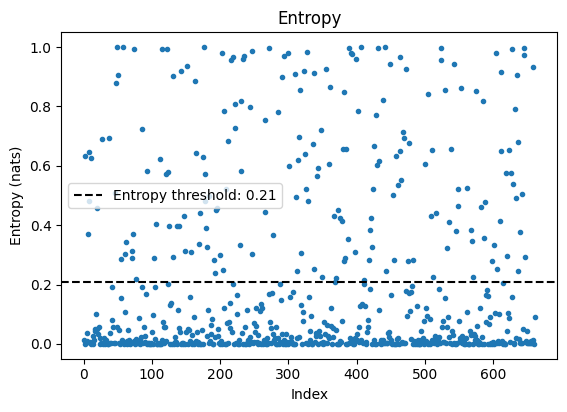

In [42]:
plot_ce(H_All_t, np.mean(H_All_t))

C:\Users\z5239493\AppData\Local\Temp\ipykernel_26864\429691185.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(ents)), ents, marker='.', c=lbls, cmap='Set1')


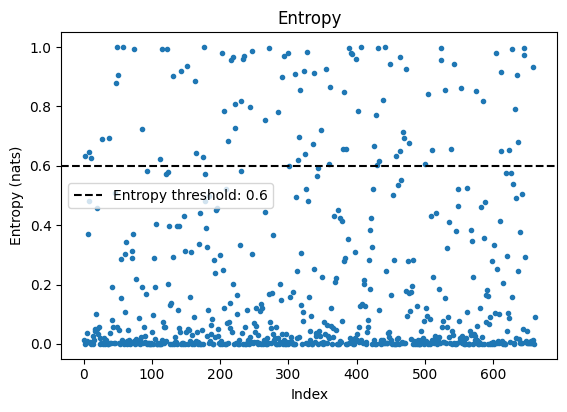

In [43]:
# assume that we don't have target's labels in UDA
plot_ce(H_All_t, ent_thres)

# DeYO - PLPD

In [44]:
print('Length data target:', xt_all.shape)

Length data target: (662, 240, 240, 3)


In [45]:
x_shuffled_t = [] # store shuffled images

for i in range(len(xt_all)):
    x_shuf_t = patch_shuffle(xt_all[i])
    x_shuffled_t.append(x_shuf_t)

print(np.array(x_shuffled_t).shape)

(662, 240, 240, 3)


In [46]:
x_shuffled_t = np.array(x_shuffled_t)

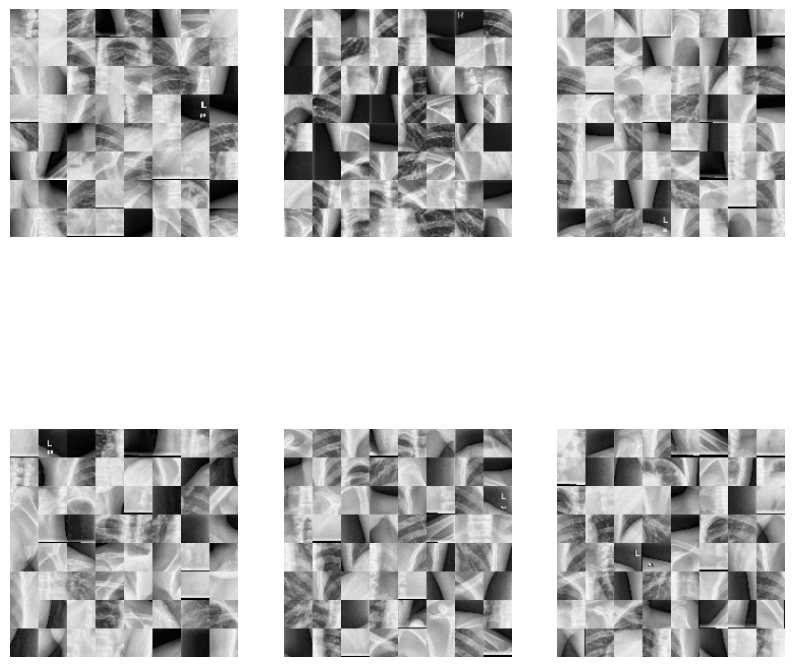

In [47]:
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(x_shuffled_t[i].astype("uint8"))
    plt.axis("off")
plt.show()

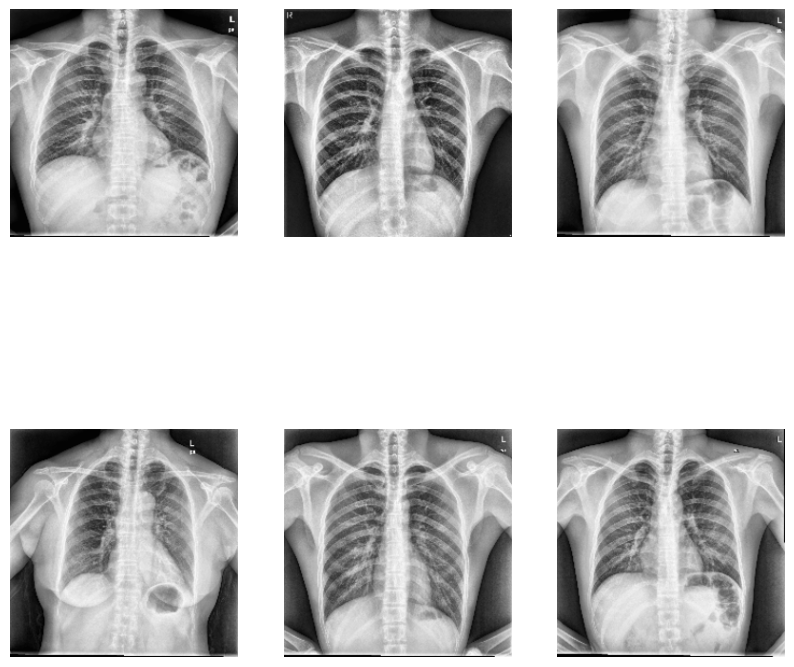

In [48]:
cl_nm = ['Normal', 'TB']
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(xt_all[i].astype("uint8"))
    # plt.title(cl_nm[yt_all[i]])
    plt.axis("off")
plt.show()

# Inference Process
# Target - destroyed (shuffled) images

In [51]:
# evaluate on unlabeled target set - shuffled/destroyed images, x_shuffled_t
summed_pred_t_sh, pred_lbl_t_sh = mod_infer(k, ft, model_ptm, x_shuffled_t)

ens_pred_t_sh = summed_pred_t_sh
ens_pred_lbl_t_sh = np.argmax(summed_pred_t_sh, axis=1)
print('Predicted labels:', len(ens_pred_lbl_t_sh), ens_pred_lbl_t_sh)
print('Summed Predict Proba:', len(ens_pred_t_sh), ens_pred_t_sh)
print('Predicted labels:', len(pred_lbl_t_sh), pred_lbl_t_sh)
print(pred_lbl_t_sh == ens_pred_lbl_t_sh)

Model name: ../../A1-TrainTest/EfficientNet-B1/n-EfficientNetB1-MC-mod-1/direct_best.h5
Model 1 head summary:
|    | Layer   | Output Shape   |   Param # |
|----|---------|----------------|-----------|
|  0 | flatten | (None, 5120)   |         0 |
|  1 | Top1    | (None, 256)    |   1310976 |
|  2 | Top2    | (None, 512)    |    131584 |
|  3 | dropout | (None, 512)    |         0 |
|  4 | TopF    | (None, 2)      |      1026 |

21/21 [==============================] - 8s 105ms/step
Predicted labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0

In [52]:
# What we have now?
print('====ORIGINAL IMAGES====')
print('Predicted labels:', len(ens_pred_lbl_t), ens_pred_lbl_t)
print('Summed Predict Proba:', len(ens_pred_t), ens_pred_t)
print('====SHUFFLED/DESTROYED IMAGES====')
print('Predicted labels:', len(ens_pred_lbl_t_sh), ens_pred_lbl_t_sh)
print('Summed Predict Proba:', len(ens_pred_t_sh), ens_pred_t_sh)

====ORIGINAL IMAGES====
Predicted labels: 662 [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [53]:
plpd_t = calc_plpd(ens_pred_t, ens_pred_t_sh, ens_pred_lbl_t)
plpd_t

array([ 4.34637070e-04,  2.45866358e-01, -5.79428673e-03,  1.07157230e-03,
       -6.25729561e-04, -3.58670950e-03, -7.08160400e-02, -1.04129791e-01,
        2.83614874e-01,  1.30360842e-01,  6.72628164e-01,  5.33925295e-02,
        1.31347954e-01,  6.25529647e-01,  2.42561817e-01,  8.90536070e-01,
        4.61356044e-02,  6.76531792e-02, -9.92506742e-03,  2.00092793e-04,
        4.48690057e-02, -9.97245312e-04,  1.57146931e-01,  4.27828252e-01,
        7.47263432e-03,  3.81741524e-02,  2.09940732e-01, -9.38647985e-02,
        3.61915231e-01,  2.58959889e-01,  2.18851984e-01,  4.08406258e-02,
        7.43210316e-04,  1.09147191e-01,  1.63781524e-01,  4.07487154e-03,
        5.27475834e-01, -1.55133545e-01,  5.41071296e-02,  1.70076489e-02,
        1.04910851e-01,  8.37084651e-02, -2.31914520e-02,  4.41743553e-01,
        2.60657907e-01,  1.50322914e-04, -9.59342718e-02,  6.15035355e-01,
        2.07560778e-01,  4.60066795e-01,  6.78808451e-01,  2.92438090e-01,
        1.93873048e-02,  

C:\Users\z5239493\AppData\Local\Temp\ipykernel_26864\837209094.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(plpds, ents, marker='.', c=lbls, cmap='Set1')


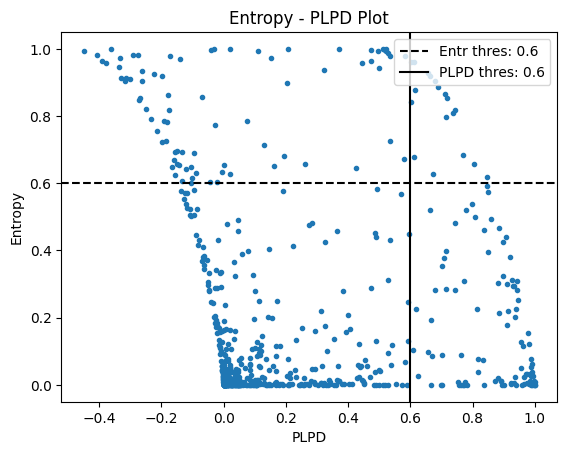

Selected images: 96 [ 13  15  54  55  59  60  75  77  83  85  97 102 112 125 129 130 133 135
 136 144 148 152 157 166 177 180 182 183 185 190 197 228 232 246 253 256
 263 273 275 280 283 287 288 295 298 307 311 316 325 335 337 344 349 354
 356 374 375 378 387 397 410 418 424 425 436 454 455 462 472 482 489 512
 514 516 527 528 534 549 552 555 557 564 567 570 571 572 574 582 603 619
 620 624 629 640 644 661]


In [54]:
plpd_t_indices = plot_ent_plpd(H_All_t, ent_thres, plpd_t, plpd_thres)
print('Selected images:', len(plpd_t_indices), plpd_t_indices)

In [55]:
# we have the original images (xt_all)
# selected images in Area 4 (low Entropy and high PLPD)
xt_plpd = xt_all[plpd_t_indices] # selected images
print(xt_plpd.shape)

(96, 240, 240, 3)


In [56]:
# change it to tensor dataset
tar_ds_plpd = tf.data.Dataset.from_tensor_slices((xt_plpd)).batch(BS)
tar_ds_plpd

<BatchDataset element_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None)>

# Domain confusion
## Build separate components so that distinct sets of gradients are easily accessed:
* feature generator
* label classifier
* domain classifier

In [58]:
ptm_mod = loadModel(k, ft, model_ptm)

Model head summary:
|    | Layer   | Output Shape   |   Param # |
|----|---------|----------------|-----------|
|  0 | flatten | (None, 5120)   |         0 |
|  1 | Top1    | (None, 256)    |   1310976 |
|  2 | Top2    | (None, 512)    |    131584 |
|  3 | dropout | (None, 512)    |         0 |
|  4 | TopF    | (None, 2)      |      1026 |



In [59]:
# check the loaded PTM weights
ptm_mod.layers[-8].get_weights()

[array([2.5303097, 2.2552214, 2.3328297, ..., 2.555408 , 2.4869387,
        2.3414533], dtype=float32),
 array([-2.293378 , -1.6896484, -1.8367051, ..., -2.1776025, -2.1319842,
        -1.7454044], dtype=float32),
 array([-0.840855  , -0.8864102 , -0.76535547, ..., -0.855082  ,
        -0.92567354, -0.7944968 ], dtype=float32),
 array([20.951813, 21.243423, 20.043224, ..., 22.217777, 21.710566,
        21.08249 ], dtype=float32)]

In [60]:
def FeatureGenerator(bmodel):
    # get all layers except for the head part (classifier)
    bmodel = Model(inputs=bmodel.input, outputs=bmodel.layers[-7].output)
    # show several last layers from built models
    # Create empty dictionary list
    layers_summary = defaultdict(list)
    # Iterate over the selected layers
    for layer in bmodel.layers[:last_layers_len]:
        layers_summary['Layer'].append(layer.name) # layer name
        layers_summary['Output Shape'].append(layer.output_shape) # layer output shape
        layers_summary['Param #'].append(layer.count_params()) # layer parameter size
    layers_summary['Layer'].append('===========') # separator
    layers_summary['Output Shape'].append('===========') # separator
    layers_summary['Param #'].append('===========') # separator
    for layer in bmodel.layers[-last_layers_len:]:
        layers_summary['Layer'].append(layer.name) # layer name
        layers_summary['Output Shape'].append(layer.output_shape) # layer output shape
        layers_summary['Param #'].append(layer.count_params()) # layer parameter size
    # Convert to pandas dataframe
    layers_df = pd.DataFrame.from_dict(layers_summary) 
    # Tabulate df
    print(tabulate(layers_df, headers = 'keys', tablefmt = 'github')+"\n")

    print("Number of layers in the Generator model: ", len(bmodel.layers))
    # loop over all layers in the model and set them as True (trainable)
    for layer in bmodel.layers:
        layer.trainable = True
    print('Number of trainable layers in the Generator model: ', len(bmodel.trainable_variables))
        
    return bmodel

feature_generator = FeatureGenerator(ptm_mod)
gen_output_shape = feature_generator.layers[-1].output_shape

|    | Layer           | Output Shape          | Param #     |
|----|-----------------|-----------------------|-------------|
|  0 | input_1         | [(None, 240, 240, 3)] | 0           |
|  1 | rescaling       | (None, 240, 240, 3)   | 0           |
|  2 | normalization   | (None, 240, 240, 3)   | 7           |
|  3 | tf.math.truediv | (None, 240, 240, 3)   | 0           |
|  4 | stem_conv_pad   | (None, 241, 241, 3)   | 0           |
|  5 | ===========     | ===========           | =========== |
|  6 | block7b_drop    | (None, 8, 8, 320)     | 0           |
|  7 | block7b_add     | (None, 8, 8, 320)     | 0           |
|  8 | top_conv        | (None, 8, 8, 1280)    | 409600      |
|  9 | top_bn          | (None, 8, 8, 1280)    | 5120        |
| 10 | top_activation  | (None, 8, 8, 1280)    | 0           |

Number of layers in the Generator model:  340
Number of trainable layers in the Generator model:  299


In [61]:
# check the loaded PTM weights
feature_generator.layers[-2].get_weights()

[array([2.5303097, 2.2552214, 2.3328297, ..., 2.555408 , 2.4869387,
        2.3414533], dtype=float32),
 array([-2.293378 , -1.6896484, -1.8367051, ..., -2.1776025, -2.1319842,
        -1.7454044], dtype=float32),
 array([-0.840855  , -0.8864102 , -0.76535547, ..., -0.855082  ,
        -0.92567354, -0.7944968 ], dtype=float32),
 array([20.951813, 21.243423, 20.043224, ..., 22.217777, 21.710566,
        21.08249 ], dtype=float32)]

In [62]:
def LabelPredictor():
    classifier = tf.keras.Sequential(
        [
            tf.keras.layers.AveragePooling2D(pool_size=(4,4)),
            tf.keras.layers.Flatten(name="flatten"),
            tf.keras.layers.Dense(128, activation='leaky_relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
            tf.keras.layers.Dense(32, activation='leaky_relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2, activation=None, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        ]
    )
    return classifier
    
label_predictor = LabelPredictor()

In [63]:
def DomainPredictor(disc_input_shape):
    inputs = tf.keras.Input(shape=disc_input_shape)
    pooling = tf.keras.layers.AveragePooling2D(pool_size=(4,4))(inputs)
    flatten = tf.keras.layers.Flatten(name="flatten")(pooling)
    dense1 = tf.keras.layers.Dense(64, activation='leaky_relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(flatten)
    dense2 = tf.keras.layers.Dense(32,activation='leaky_relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense1)
    dropout = tf.keras.layers.Dropout(0.2)(dense2)
    
    # For FADA, using 'None' for activation until softmax is required for probability dist
    source_out = tf.keras.layers.Dense(2, activation=None, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dropout)
    target_out = tf.keras.layers.Dense(2, activation=None, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dropout)
    
    outputs = tf.stack([source_out, target_out], axis=-1)

    discriminator = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    
    return discriminator

domain_predictor = DomainPredictor(gen_output_shape[1:])

In [64]:
# rather than using the ori tar_ds and sc_train_ds, we are using selected images (area 4 PLPD-Entropy): tar_ds_plpd and sc_ds_plpd

for img in tar_ds_plpd:
    print(img[0].shape)
print('='*100)
for img in sc_train_ds:
    print(img[0].shape)

(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)
(8, 240, 240, 3)

In [65]:
# Separate optimizers to allow different learning rates
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
d_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

generator_optimiser = tf.keras.optimizers.Adam(learning_rate=INIT_LR) # feature generator opt
classifier_optimiser = tf.keras.optimizers.Adam(learning_rate=INIT_LR*10) # classifier opt
discriminator_optimiser = tf.keras.optimizers.Adam(learning_rate=INIT_LR*0.1) # discriminator opt

In [66]:
# Discriminative losses
sc_train_loss = tf.keras.metrics.Mean(name='sc_train_loss')
sc_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_train_accuracy')

sc_test_loss = tf.keras.metrics.Mean(name='sc_test_loss')
sc_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_test_accuracy')

tar_test_loss = tf.keras.metrics.Mean(name='tar_test_loss')
tar_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='tar_test_accuracy')

In [67]:
def soft_label_crossentropy(pred, soft_label):
    loss = -soft_label * tf.nn.log_softmax(pred, axis=-1)
    return tf.reduce_mean(tf.reduce_sum(loss, axis=0))

In [68]:
# function to make a new directory to save best models
def checkmakeDir(mdir):
    # check if dir exist, if not make it
    if not(os.path.isdir(mdir)):
        Path(mdir).mkdir(parents=True, exist_ok=True)
        print("New Directory successfully made!")
    else:
        print("Directory already exist!")

In [69]:
checkmakeDir(save_dir)

Directory already exist!


In [70]:
def elr_loss(pred, smoothed_pred):
    loss = tf.math.log(tf.ones([2,2]) - tf.transpose(smoothed_pred) @ pred)
    return tf.reduce_mean(tf.reduce_sum(loss, axis=0))

# Adversarial Training

In [71]:
def train_step(epo, bi, sc_images, sc_labels, tar_imgs, alpha, beta, lamda):
    """
    i. sc_images = batch of source images (train)
    ii. sc_labels = corresponding labels (train)
    iii. tar_imgs = batch of target images (train)
    iv. alpha = weight attributed to the domain loss
    v. beta = weight attributed to the MA prediction on target images (smoothing)
    """
    temperature = 1.8 # TEMPERATURE: Used in collecting soft_labels
    
    ## Update the generator and the classifier
    with tf.GradientTape(persistent=True) as tape:
        # First step, classify source sample for soft_label and calc loss for classifier and generator
        sc_features = feature_generator(sc_images, training=True)
        sc_predictions = label_predictor(sc_features, training=True)
        sc_predictions = tf.math.divide(sc_predictions, tf.constant(temperature))
        sc_label_loss = loss_object(sc_labels, sc_predictions)

        # generate soft labels
        source_soft_label = tf.keras.activations.softmax(sc_predictions)
        source_soft_label = tf.where(source_soft_label>conf_thres, conf_thres, source_soft_label) #Custom activation, 0.9 hard ceiling
        source_soft_label = tf.convert_to_tensor(source_soft_label)
        source_soft_label = tf.expand_dims(source_soft_label, axis=1)

        # Second step, classify target sample for soft_label
        tar_features = feature_generator(tar_imgs, training=True)
        tar_predictions = label_predictor(tar_features, training=True)
        tar_predictions = tf.math.divide(tar_predictions, tf.constant(temperature))

        # Single smoothing tech
         
        if (epo == 0):
            tar_preds_t = tar_predictions
        else:
            tar_preds_t = (beta * tar_preds_tmin1[(bi*BS):((bi+1)*BS)]) + ((1 - beta) * tar_predictions) # as in the source
            
        tar_preds_tmin1[(bi*BS):((bi+1)*BS)] = tar_preds_t

        if (epo == 0):
            print('tar_preds_t:', tar_preds_t)
            print('='*30)
            print('tar_preds_tmin1:', tar_preds_tmin1)
        
        target_soft_label = tf.keras.activations.softmax(tar_preds_t)
        target_soft_label = tf.where(target_soft_label>conf_thres, conf_thres, target_soft_label) #Custom activation, 0.9 hard ceiling
        target_soft_label = tf.convert_to_tensor(target_soft_label)
        target_soft_label = tf.expand_dims(target_soft_label, axis=1)
        
        # Third step, calculate and apply adversarial loss to discriminator (confuse discriminator by feeding a target_soft_label posing as a source_soft_label)
        tar_disc_preds = domain_predictor(tar_features, training=True)
        adversarial_loss = alpha * soft_label_crossentropy(tar_disc_preds, tf.concat((target_soft_label, tf.zeros_like(target_soft_label)), axis=1))

        # calculate final loss (loss_adv + lambda * loss_elr)
        print(tf.transpose(tar_preds_t) @ tar_predictions)
        fin_adv_loss = adversarial_loss + lamda * elr_loss(tar_predictions, tar_preds_t)
        
    # For class prediction - on Source training set
    sc_train_loss(sc_label_loss)
    sc_train_accuracy(sc_labels, source_soft_label)
    print('Actual labels on Source train:\n', sc_labels.shape, '\n', sc_labels[:2])
    print('Predicted labels on Source train:\n', source_soft_label.shape, '\n', source_soft_label[:2])
    print('Source train accuracy:', sc_train_accuracy(sc_labels, source_soft_label))

    classifier_grads = tape.gradient(sc_label_loss, label_predictor.trainable_variables)
    classifier_optimiser.apply_gradients(zip(classifier_grads, label_predictor.trainable_variables))

    generator_grads = tape.gradient([sc_label_loss, fin_adv_loss], feature_generator.trainable_variables)
    generator_optimiser.apply_gradients(zip(generator_grads, feature_generator.trainable_variables))
    
    with tf.GradientTape() as disc_tape:
        # Fourth step, calculate and apply discriminator loss of source sample using soft_label
        sc_disc_preds = domain_predictor(sc_features, training=True)
        loss_ds = 0.5 * soft_label_crossentropy(sc_disc_preds, tf.concat((source_soft_label, tf.zeros_like(source_soft_label)), axis=1))
        
        # Fifth step, calculate and apply discriminator loss of target sample using soft_label
        tar_disc_preds = domain_predictor(tar_features, training=True)
        loss_dt = 0.5 * soft_label_crossentropy(tar_disc_preds, tf.concat((tf.zeros_like(target_soft_label), target_soft_label), axis=1))
          
    discriminator_grads = disc_tape.gradient([loss_ds, loss_dt], domain_predictor.trainable_variables)
    discriminator_optimiser.apply_gradients(zip(discriminator_grads, domain_predictor.trainable_variables))
    
    return tar_preds_t

In [72]:
def test_step(sc_images, sc_labels, tar_images, tar_labels):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    source_features = feature_generator(sc_images)
    source_logits = label_predictor(source_features)
    source_predictions = tf.keras.activations.softmax(source_logits)
    sc_t_loss = loss_object(sc_labels, source_predictions)
    
    sc_test_loss(sc_t_loss)
    sc_test_accuracy(sc_labels, source_predictions)
    
    print('Predictions on Source:\n', source_predictions.shape, '\n', source_predictions[:5])
    print('Source acc:', sc_test_accuracy(sc_labels, source_predictions))

    target_features = feature_generator(tar_images)
    target_logits = label_predictor(target_features)
    target_predictions = tf.keras.activations.softmax(target_logits)
    tar_t_loss = loss_object(tar_labels, target_predictions)
    
    tar_test_loss(tar_t_loss)
    tar_test_accuracy(tar_labels, target_predictions)
    
    print('Predictions on Target:\n', target_predictions.shape, '\n', target_predictions[:5])
    print('Target acc:', tar_test_accuracy(tar_labels, target_predictions))
    print('='*50)
    
    return sc_t_loss, tar_t_loss

In [73]:
def reset_metrics():
    sc_train_loss.reset_states()
    sc_train_accuracy.reset_states()
    sc_test_loss.reset_states()
    sc_test_accuracy.reset_states()
    tar_test_loss.reset_states()
    tar_test_accuracy.reset_states()

In [75]:
# run this several times according to the k classifiers
for i in range(k):
    
    accumulated_patience = 0
    highest_acc = 0
    acc_t_history, loss_t_history = [], []
    acc_s_history, loss_s_history = [], []
    n_samples = np.min([len(xs_train), len(xt_plpd)]) # choose the minimum data between source and target - (selected via plpd)
    tar_preds_tmin1 = np.zeros((n_samples, 2)) # init with zeros
    
    for epoch in range(EPOCH):
        reset_metrics()
        
        print('========EPOCH', epoch+1, '=========')
        # Adversarial Training process 
        bi = 0
        for sc_train_data, tar_data in zip(sc_train_ds, tar_ds_plpd):
            try:
                train_step(epoch, bi, sc_train_data[0], sc_train_data[1], tar_data, alpha=alpha, beta=beta, lamda=lamda)
                bi += 1
            #End of the smaller dataset
            except ValueError: 
                pass
        print('+++++++ Updated per EPOCH y_bar_tmin1 ++++++++ \n', tar_preds_tmin1)
        
        # Evaluation on source test and all target datasets
        for sc_test_data, tar_data in zip(sc_test_ds, tar_ds):
            sc_loss, tar_loss = test_step(sc_test_data[0], sc_test_data[1], tar_data[0], tar_data[1])
      
        template = 'Epoch {}, Train Accuracy: {}, Source Test Accuracy: {}, Target Accuracy: {}'
        print(template.format(epoch+1,
                             sc_train_accuracy.result()*100,
                             sc_test_accuracy.result()*100,
                             tar_test_accuracy.result()*100,))
    
        print('='*50)
        print('Source Loss:', sc_test_loss(sc_loss), '\nTarget Loss:', tar_test_loss(tar_loss))

        acc_t_history.append(tar_test_accuracy.result()*100)
        loss_t_history.append(tar_test_loss.result())
        acc_s_history.append(sc_test_accuracy.result()*100)
        loss_s_history.append(sc_test_loss.result())
    
        if (acc_t_history[-1] > highest_acc): 
            print('New best acc on target! Saving models...')
            tf.keras.Model.save(label_predictor, save_dir+'/'+model_name+"_FADAPS4_"+str(ft)+"_"+str(i+1)+'lab_pred.h5', overwrite=True, save_format='h5')
            tf.keras.Model.save(feature_generator, save_dir+'/'+model_name+"_FADAPS4_"+str(ft)+"_"+str(i+1)+'feat_gen.h5', overwrite=True, save_format='h5')
            accumulated_patience = 0
            highest_acc = acc_t_history[-1]
            print('Highest acc found:', highest_acc)
        else:
            accumulated_patience += 1
    
        print("=+++="*50)
        # Check if training patience has been reached to prevent overfitting
        if accumulated_patience >= patience:
            print('Exiting training loop, patience reached after', epoch+1, ', epochs with highest acc of', highest_acc)
            break


========EPOCH 1 =========
tar_preds_t: tf.Tensor(
[[ 0.01789538  0.14168185]
 [ 0.6997824  -0.5417349 ]
 [ 0.02717641  0.07331944]
 [ 0.5122041  -0.58379865]
 [-0.06754338 -0.43602848]
 [ 0.42186707 -0.24943049]
 [ 0.16364418 -0.12741707]
 [-0.25020647  0.02241098]], shape=(8, 2), dtype=float32)
tar_preds_tmin1: [[ 0.01789538  0.14168185]
 [ 0.69978237 -0.54173487]
 [ 0.02717641  0.07331944]
 [ 0.51220411 -0.58379865]
 [-0.06754338 -0.43602848]
 [ 0.42186707 -0.24943049]
 [ 0.16364418 -0.12741707]
 [-0.25020647  0.02241098]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.      

In [77]:
# Load the best saved model
FADARPSPath = save_dir+'/'+model_name+"_FADAPS4_"+str(ft)+"_"+str(i+1)

In [78]:
# function to check the model accuracy on Test set
def perfEvalADA(k, ft, model_v, test_ds):
    pred_ens = []
    for i in range(k):
        print('Model name:', model_v)
        classifier = load_model(model_v+'lab_pred.h5')
        generator = load_model(model_v+'feat_gen.h5')

        y_pred = []  # store predicted labels
        y_true = []  # store true labels
        y_prob = []  # store predict proba labels
        # iterate over the dataset
        for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
            print("-------------------------------")
            # append true labels
            y_true.append(label_batch)
            # compute predictions
            g_out = generator(image_batch)
            g_logits = classifier(g_out)
            preds = tf.keras.activations.softmax(g_logits)
            # append predicted labels
            y_pred.append(np.argmax(preds, axis = -1))
            # append predict proba labels - for auc curve
            y_prob.append(preds)
        # convert the true and predicted labels into tensors
        correct_labels = tf.concat([item for item in y_true], axis = 0)
        predicted_labels = tf.concat([item for item in y_pred], axis = 0)
        proba_labels = tf.concat([item for item in y_prob], axis = 0)
        # add the prediction results into pred_ens
        pred_ens.append(proba_labels)
        print("================================")
    
        print('1A. Single (Direct) Prediction Results')
        print('Actual labels: ', correct_labels)
        print('Predicted labels:', predicted_labels)
        acc, sens, spec, prec, f1 = perf_metrics(correct_labels, predicted_labels)
        # convert proba_labels to np.array
        proba_labels = np.array(proba_labels)
        # calculate the ROC AUC
        fpr, tpr, threshold = metrics.roc_curve(correct_labels, proba_labels[:,1])
        roc_auc = metrics.auc(fpr, tpr)
        # plot the curve
        plt.title('Receiver Operating Characteristic AUC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %.4f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        print('============================')

    print('Ensemble Prediction Model using', k,' Classifiers')
    predicted_ens = [pred_ens[j] for j in range(k)]
    predicted_ens = np.array(predicted_ens)
    # sum across ensemble results
    summed = np.sum(predicted_ens, axis=0)
    # argmax across classes as our prediction results
    ens_pred_labels = np.argmax(summed, axis=1)
    print('Actual labels: ', correct_labels)
    print('Predicted labels:', ens_pred_labels)
    acc, sens, spec, prec, f1 = perf_metrics(correct_labels, ens_pred_labels)
    # calculate the ROC AUC
    fpr, tpr, threshold = metrics.roc_curve(correct_labels, summed[:,1]/k)
    roc_auc = metrics.auc(fpr, tpr)
    # plot the curve
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('============================')
    
    del fpr, tpr, threshold
    return acc, sens, spec, prec, f1, roc_auc, proba_labels, correct_labels

Model name: FADAPS4-mods/PTM-MC-SZ-e06p06b07l7v3_FADAPS4_340_1
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
---------

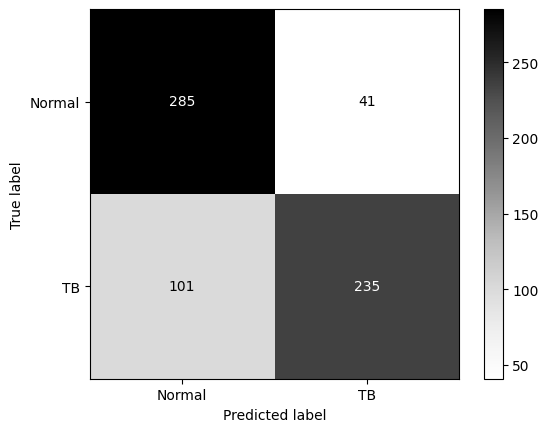


Accuracy: 78.5498

Recall/Sensitivity: 69.9405

Specificity: 87.4233

Precision: 85.1449

F1-score: 76.7974



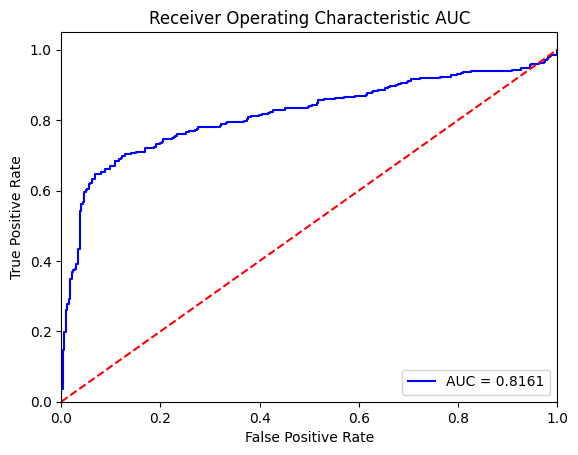

Ensemble Prediction Model using 1  Classifiers
Actual labels:  tf.Tensor(
[1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1
 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 0 1 1 0 1 0 1

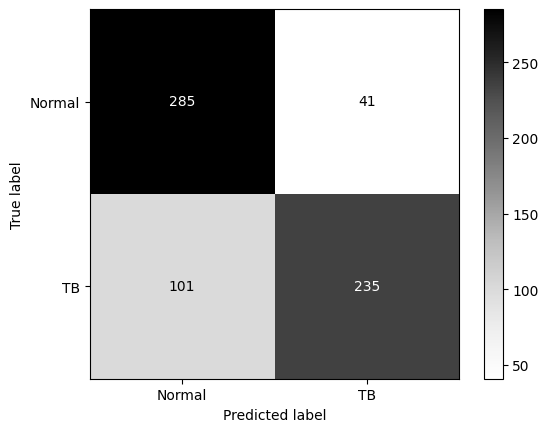


Accuracy: 78.5498

Recall/Sensitivity: 69.9405

Specificity: 87.4233

Precision: 85.1449

F1-score: 76.7974



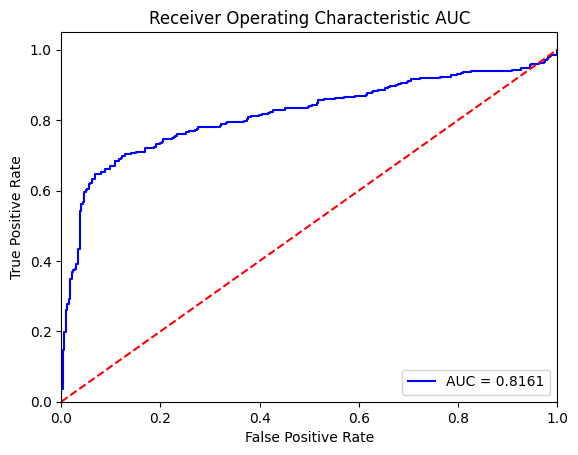

Execution time: 52.532793599995784
Actual labels:  tf.Tensor(
[1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0
 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1
 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1
 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1

In [79]:
# evaluate
start_counter = time.perf_counter()
acc, sens, spec, prec, f1, roc_auc, summed_pred, act_lbl = perfEvalADA(k, ft, FADARPSPath, tar_ds)
end_counter = time.perf_counter()
timer = end_counter - start_counter
print('Execution time:', timer)

print('Actual labels: ', act_lbl)
ens_pred = summed_pred
ens_pred_lbl = np.argmax(summed_pred, axis=1)
print('Predicted labels:', ens_pred_lbl)
print('Summed Predict Proba:', ens_pred)